# Предсказание победы в Dota 2: Руководство по решению


### Быстрый старт

Берем подготовленные организаторами таблицы с признаками, обучаем модель и отправляем предсказания в систему (как на он-лайн туре) — изи.

1. [Описание данных](#Описание-данных)
2. [Таблицы с признаками от организаторов](#Таблицы-с-признаками-от-организаторов)
3. [Построение модели и оценка качества](#Построение-модели-и-оценка-качества)
4. [Подготовка решения](#Подготовка-решения)

### Работаем как крутые аналитики данных

5. [Кросс валидация: более надежная оценка качества](#Кросс-валидация:-более-надежная-оценка-качества)
6. [Работа с полными описаниями матчей](#Работа-с-полными-описаниями-матчей)
7. [Добавление новых признаков](#Добавление-новых-признаков)
8. [Как построить таблицу признаков с нуля](#Как-построить-таблицу-признаков-с-нуля)

## Описание данных

Архив с данными содержит следующие файлы:

- `sample_submission.csv`: пример файла с решением
- `train_matches.jsonl`, `test_matches.jsonl`: полные описания матчей ("сырые" данные)
- `train_features.csv`, `test_features.csv`: таблицы с признаками от организаторов 
- `train_targets.csv`: таблица с исходами матчей из обучающей выборки, в частности указание победителя

## Таблицы с признаками от организаторов

Таблицы с признаками были подготовлены организаторами, в них каждый матч описывается его базовыми параметрами, для каждого игрока приведен набор статистик на момент остановки матча. О том как подготовить такую таблицу из сырых данных — смотрите далее. 

In [1]:
import pandas

df_train_features = pandas.read_csv('data_final/train_features.csv', index_col='match_id_hash')
df_train_targets = pandas.read_csv('data_final/train_targets.csv', index_col='match_id_hash')

В таблице признаков есть колонка-индекс `match_id_hash` (идентификатор матча) и 245 колонок с признаками. Всего примеров матчей в обучающей выборке — почти 40 тысяч. Самый первый признак `game_time` — время когда матч был остановлен (в секундах). 

In [2]:
# размер таблицы
df_train_features.shape

(39675, 245)

In [3]:
# посмотреть кусочек таблицы
df_train_features.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                      ...        d5_stuns  d5_creeps_stacked  \
match_id_hash                         ...                                      
a400b8f29dece5f4d266f49f1ae2e98a      ...        0.000000                  0   
b9c57c450ce74a2af79c9ce96fac144d      ...        0.000000                  0   
6db558535151ea18ca70a6892197db41      ...        0.000000                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682      ...        8.664527                  3   
b1b35ff97723d9b7ade1c9c3cf48f770      ...        0.000000                  2   

                                  d5_camps_stacked  d5_rune_pickups  \
match_id_hash                                                         
a400b8f29dece5f4d266f49f1ae2e98a                 0                0   
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 1                3   
b1b35ff97723d9b7ade1c9c3cf48f770                 1                2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                             

Таблица `train_targets.csv` содержит информацию "из будущего" — то что неизвестно на момент, когда часы показывают `game_time`. Нас будет интересовать колонка `radiant_win` — в ней записано, победит команда Radiant или нет — это целевое событие, вероятность кооторого нужно оценивать. Для тестовой выборки такой информации нет.

In [4]:
df_train_targets.head()

game_time  radiant_win  duration  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155        False       992   
b9c57c450ce74a2af79c9ce96fac144d        658         True      1154   
6db558535151ea18ca70a6892197db41         21         True      1503   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         True      1952   
b1b35ff97723d9b7ade1c9c3cf48f770        453        False      2001   

                                  time_remaining next_roshan_team  
match_id_hash                                                      
a400b8f29dece5f4d266f49f1ae2e98a             837              NaN  
b9c57c450ce74a2af79c9ce96fac144d             496              NaN  
6db558535151ea18ca70a6892197db41            1482          Radiant  
46a0ddce8f7ed2a8d9bd5edcbb925682            1376              NaN  
b1b35ff97723d9b7ade1c9c3cf48f770            1548              NaN

## Построение модели и оценка качества

#### Построим числовую матрицу объект-признак `X` и вектор ответов `y`

In [5]:
X = df_train_features.values
y = df_train_targets['radiant_win'].values

#### Простой способ оценки качества: выделить контрольную подвыборку (validation)

При помощи функции [`train_test_split()`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) разбиваем размеченную обучающую выборку на две — 1) новая обучающая `X_train` и 2) контрольная (валидационная) `X_valid`. В качестве параметра функции передается желаемый размер валидационной подвыборки (в нашем случае это 0.3, что означает 30% от размера). Для того чтобы при разных запусках получать одно и то же разбиение, необходимо указать параметр `random_state` — число, которым инициализируется генератор случайных чисел.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

#### Обучаем  модель

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Строим предсказания на валидационной выборке

У моделей классификации в SciKit-Learn метод `model.predict(X)` дает вектор с точными предсказаниями (например: 0 или 1). Большинство алгоритмов классификации имеют дополнительный метод — `model.predict_proba(X)`, который оценивает вероятность каждого класса и возвращает матрицу, в которой строчка соответствует объекту, а столбец — классу. Нас интересует вероятность победы Radiant, т.е. вероятность первого класса, поэтому возьмем у матрицы колонку с индексом `1`:

In [8]:
y_pred = model.predict_proba(X_valid)[:, 1]

Получаем вот такие предсказания на валидационной выборке:

In [9]:
y_pred

array([ 0.58,  0.52,  0.44, ...,  0.54,  0.51,  0.16])

#### Оценим качество предсказаний на валидационной выборке

Посчитаем на валидационных примерах метрику ROC-AUC.

In [10]:
from sklearn.metrics import roc_auc_score

valid_score = roc_auc_score(y_valid, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.776373160868


Можем для интереса посчитать долю правильных ответов для классификатора, который принимает решение 1 если вероятность больше 50%

In [11]:
from sklearn.metrics import accuracy_score

valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print('Validation accuracy of P>0.5 classifier:', valid_accuracy)

Validation accuracy of P>0.5 classifier: 0.698647399815


## Подготовка решения

Воспользуемся обученной выше моделью, предскажем вероятность победы Radiant для всех тестовых примеров.

In [12]:
df_test_features = pandas.read_csv('data_final/test_features.csv', index_col='match_id_hash')

X_test = df_test_features.values
y_test_pred = model.predict_proba(X_test)[:, 1]

df_submission = pandas.DataFrame({'radiant_win_prob': y_test_pred}, index=df_test_features.index)

In [13]:
df_submission.head()

radiant_win_prob
match_id_hash                                     
30cc2d778dca82f2edb568ce9b585caa              0.54
70e5ba30f367cea48793b9003fab9d38              0.85
4d9ef74d3a2025d79e9423105fd73d41              0.80
2bb79e0c1eaac1608e5a09c8e0c6a555              0.50
bec17f099b01d67edc82dfb5ce735a43              0.43

Сохраняем предсказания в файл, их можно отправлять в систему. Для удобства в названии файла указываем дату и время.

In [14]:
import datetime
submission_filename = 'submission_{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2018-04-21_08:57:32.csv


## Кросс-валидация: более надежная оценка качества

Кросс-валидация — это продвинутый способ оценить качество модели на обучающей выборке. В любом разбиении на обучение и контроль есть случайность — из-за этой случайности оценка качества может оказаться завышенной или наоборот — заниженной, это может привести к тому что участник выберет не самую лучшую модель и на лидерборде получит не самый лучший результат.

Давайте сделаем много случайных разбиений на обучение/валидацию и проверим качество на каждом.

Для этого в SciKit-Learn есть модуль [`model_selection`](http://scikit-learn.org/stable/modules/cross_validation.html). В нем есть удобная функция [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) позволяющая считать качество модели на наборе разбиений. Также в модуле есть различные генераторы разбиений, например:

- [`ShuffleSplit`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) — генерирует заданное число случайных разбиений в заданном соотношении,
- [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) — генерирует разбиения по специальной схеме при которой каждый объект попадает в валидационную подвыборку ровно один раз.

#### Создаем разбиение исходной обучающей выборки `X`

In [15]:
from sklearn.model_selection import ShuffleSplit, KFold

# Создаем 5 разбиений в соотношении — обучение 70% / валидация 30%
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=123)

In [16]:
from sklearn.model_selection import cross_val_score

#### Запускаем кросс-валидацию

Оценим качество алгоритма `RandomForestClassifier` с разными параметрами — в первом случае будем строить полное дерево, во втором случае — ограничивать по высоте, так чтобы в листьях было хотя бы 3 примера.

Кросс-валидация требует обучать модель много раз подряд, поэтому этот процесс может занимать значительное время. Время хакатона ограничено. Поэтому для ускорения рекомендуется следующее:

- делайте небольшое число разбиений (будет работать быстрее, но оценка будет менее надежная)
- используйте сразу все процессоры вашего компьютера и распараллеливайте, указывая параметр `n_jobs`

In [17]:
%%time

model_rf1 = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# вычисляем ROC-AUC на всех построенных разбиениях cv
cv_scores_rf1 = cross_val_score(model_rf1, X, y, cv=cv, scoring='roc_auc')

CPU times: user 1min 38s, sys: 1.76 s, total: 1min 40s
Wall time: 1min 39s


In [18]:
%%time

model_rf2 = RandomForestClassifier(n_estimators=100, min_samples_leaf=3, random_state=42)

# оценка качества на разных разбиениях может делаться параллельно на разных процессорах
# для того чтобы включить паралелльность нужно указать n_jobs=<число процессоров>, -1 — автоматический подбор
cv_scores_rf2 = cross_val_score(model_rf2, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

CPU times: user 819 ms, sys: 109 ms, total: 928 ms
Wall time: 51.1 s


#### Смотрим на результаты кросс-валидации

Результат работы `cross_val_score` — массив с подсчитаным ROC-AUC по всем разбиениям. Посмотрим на них:

In [19]:
cv_scores_rf1

array([ 0.78369011,  0.77511895,  0.77475305,  0.77617993,  0.7790677 ])

In [20]:
cv_scores_rf2

array([ 0.7860284 ,  0.77848457,  0.78023516,  0.77829629,  0.77878609])

Посчитаем средний ROC-AUC для всех разбийний и сравним:

In [21]:
print('Model 1 mean score:', cv_scores_rf1.mean())
print('Model 2 mean score:', cv_scores_rf2.mean())

Model 1 mean score: 0.77776194679
Model 2 mean score: 0.780366101399


Вторая модель имеет в среднем лучший результат. Это значит, что лучше взять именно ее. Но, обратите внимание: только на 4х из 5 разбиений мы выявили лучшее качество. Если бы мы использовали одно разбиение, то с вероятностью 1:5 мы сделали бы вывод о том, что вторая модель работает хуже.

In [22]:
cv_scores_rf2 > cv_scores_rf1

array([ True,  True,  True,  True, False], dtype=bool)

## Работа с полными описаниями матчей

Полные описания матчей ("сырые" данные) представлены в файлах `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит по одной строчке на матч — в строчке записан объект, закодированный в формате [JSON](https://en.wikipedia.org/wiki/JSON). Про JSON достаточно знать лишь то, что его можно лего переводить в Python-объекты (словари, спики, числа, строки и тд) при помощи функции `json.loads`.

##### Посмотрим на одну строчку из файла

In [23]:
import json

with open('data_final/train_matches.jsonl') as fin:
    # Прочитаем 18-ю строчку из файла
    for i in range(18):
        line = fin.readline()
    
    # расшифруем формат JSON в обычный Python-объект
    match = json.loads(line)

Обект `match` — это большой словарь, в полях которого есть значения и другие вложенные словари. В частности есть массив `match['players']` в котором записано описание каждого игрока.

Объект `match` — это и есть те данные, в том виде, в котором они встречаются в реальной жизни, на практике. Подробное описание полей есть в руководстве по задаче. Помните, что настоящий специалист по анализу данных может не вдаваться глубоко в предметную область (в данном контексте это означает что можно практически ничего не знать про игру Dota 2), для того чтобы найти сложную закономерность в данных; в этом искусство и сила специалистов по Data Science.

In [24]:
#match

#### Объекты с описанием игроков

In [25]:
player = match['players'][2]

KDA: число убийств, смертей и помощи союзникам

In [26]:
player['kills'], player['deaths'], player['assists']

(8, 11, 12)

Статистика по использованию умений игрока:

In [27]:
player['ability_uses']

{'kunkka_ghostship': 16,
 'kunkka_return': 1,
 'kunkka_torrent': 43,
 'kunkka_x_marks_the_spot': 8}

#### Пример: временной ряд изменения золота во всем игрокам

In [28]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


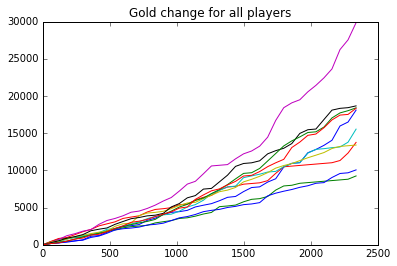

In [29]:
for player in match['players']:
    plot(player['times'], player['gold_t'])
    
title('Gold change for all players')

#### Функция для чтения файла с матчами

Далее приведена функция `read_matches(filename)`, которую можно использовать для чтения объектов из файлов с сырыми данными.

Рекомендуется установить два Python пакета: `ujson` и `tqdm`, без них чтение будет работать дольше и не будет прогресс-бара.

In [30]:
import os

try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Установите пакет ujson для того чтобы декодировать JSON-объекты быстрее')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Установите пакет tqdm для того чтобы видеть прогресс и оценку времени завершения')

def read_matches(matches_file):
    
    # Число матчей, нужно того чтобы видеть Progress Bar и оценку времени завершения
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

#### Чтение матчей в цикле

Чтение всех матчей может занять 2-3 минуты. Поэтому очень важно во время хакатона следовать следующему алгоритму:

1. Прочитайте небольшое число матчей (10-100)
2. Напишите код, который извлекает из матча нужные признаки или считает нужную статистику
3. Убедитесь что код работает без ошибок
4. Запустите полный прогон вашего алгоритма по всем матчам
5. Сохраните результат в CSV-таблицу или при помощи `pickle`, для того чтобы его не пришлось вычислять заново

In [31]:
for match in read_matches('data_final/train_matches.jsonl'):
    match_id_hash = match['match_id_hash']
    game_time = match['game_time']
    
    # обработка матча
    
    for player in match['players']:
        pass  # обработка игрока

HBox(children=(IntProgress(value=0, max=39675), HTML(value='')))

## Добавление новых признаков

In [32]:
def add_new_features(df_features, matches_file):
    
    # Пройдем по сырым данным и добавим новые признаки в таблицу
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Подсчет числа разбитых Башен для обеих команд
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Записываем в таблицу значения признаков
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        # ... здесь вы можете дописать свои собственные признаки ...
        

In [33]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые признаки
add_new_features(df_train_features_extended, 'data_final/train_matches.jsonl')

HBox(children=(IntProgress(value=0, max=39675), HTML(value='')))

В последних колонках видим новые признаки

In [34]:
df_train_features_extended.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                        ...         d5_rune_pickups  \
match_id_hash                           ...                           
a400b8f29dece5f4d266f49f1ae2e98a        ...                       0   
b9c57c450ce74a2af79c9ce96fac144d        ...                       0   
6db558535151ea18ca70a6892197db41        ...                       0   
46a0ddce8f7ed2a8d9bd5edcbb925682        ...                       3   
b1b35ff97723d9b7ade1c9c3cf48f770        ...                       2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                                  d5_obs_placed  d5_sen_placed  \
match_id_hash                                                    
a400b8f29dece5f4d266f49f1ae2e98a              0              0   
b9c57c450ce74a2af79c9ce96fac144d              0              0   
6db558535151ea18ca70a6892197db41              0              0   
46a0ddce8f7ed2a8d9bd5edcbb925682              2              0   
b1b35ff97723d9b7ade1c9c3cf48f770              0              0   

                                  radiant_tower_kills  dire_tower_kills  \
match_id_hash                                       

#### Оценка улучшения качества

Запустим кросс-валидацию и сравним одну и ту же модель на разных признаковых описаниях:

1. от организаторов (base)
2. с добавлением тех что мы только что построили (extended)

In [35]:
%%time

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

cv_scores_base = cross_val_score(model, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
cv_scores_extended = cross_val_score(model, df_train_features_extended.values, y, cv=cv, scoring='roc_auc', n_jobs=-1)

CPU times: user 1.63 s, sys: 439 ms, total: 2.07 s
Wall time: 13.6 s


In [36]:
print('Base features: mean={} scores={}'.format(cv_scores_base.mean(), cv_scores_base))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), cv_scores_extended))

Base features: mean=0.7128933102889562 scores=[ 0.7131916   0.70902319  0.71416197  0.71504327  0.71304652]
Extended features: mean=0.7292038457525152 scores=[ 0.72860431  0.72630564  0.72536915  0.73350007  0.73224005]


In [46]:
cv_scores_extended > cv_scores_base

array([ True,  True,  True,  True,  True], dtype=bool)

В результате кросс-валидации выяснили: `RandomForestClassifier` на расширенном наборе признаков дает значительный прирост по качеству (в соответствии с метрикой ROC-AUC). Это логично — чем больше признаков, тем больше информации на вход получает модель, тем потенциально лучше она может предсказывать.

#### Подготовка решения

In [38]:
# Добавим те же признаки в тестовую выборку
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, 'data_final/test_matches.jsonl')

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

In [39]:
model = RandomForestClassifier()
model.fit(X, y)
df_submission_base = pandas.DataFrame(
    {'radiant_win_pred': model.predict_proba(df_test_features.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_base.to_csv('submission_base_rf.csv')

In [40]:
model_extended = RandomForestClassifier()
model_extended.fit(df_train_features_extended.values, y)
df_submission_extended = pandas.DataFrame(
    {'radiant_win_pred': model_extended.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_submission_extended.to_csv('submission_extended_rf.csv')

## Как построить таблицу признаков с нуля

Ниже приведен код, которым организаторы построили таблицы `train_features.csv` и `test_features.csv`. Это быстрый и эффективный способ извлечь сразу много новых признаков. Вы можете модифицировать этот код, менять и добавлять свои признаки.

Принцип работы кода следующий:

1. функция `extract_features_csv(match)` извлекает признаки из матча и записывает их в словарь
2. функция `extract_targets_csv(match, targets)` извлекает целевые переменные (в частности — `radiant_win`)
3. итерируя по файлу с матчами, собираем в список все извлеченные признаки и целевые переменные
4. при помощи `pandas.DataFrame.from_records()` создаем таблицы из построенных списокв

In [41]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [42]:
%%time

df_new_features = []
df_new_targets = []

for match in read_matches('data_final/train_matches.jsonl'):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)
    

HBox(children=(IntProgress(value=0, max=39675), HTML(value='')))


CPU times: user 1min 12s, sys: 3.68 s, total: 1min 16s
Wall time: 1min 17s


In [43]:
df_new_features = pandas.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pandas.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [44]:
df_new_features.head()

game_time  game_mode  lobby_type  \
match_id_hash                                                        
a400b8f29dece5f4d266f49f1ae2e98a        155         22           7   
b9c57c450ce74a2af79c9ce96fac144d        658          4           0   
6db558535151ea18ca70a6892197db41         21         23           0   
46a0ddce8f7ed2a8d9bd5edcbb925682        576         22           7   
b1b35ff97723d9b7ade1c9c3cf48f770        453         22           7   

                                  objectives_len  chat_len  r1_hero_id  \
match_id_hash                                                            
a400b8f29dece5f4d266f49f1ae2e98a               1        11          11   
b9c57c450ce74a2af79c9ce96fac144d               3        10          15   
6db558535151ea18ca70a6892197db41               0         0         101   
46a0ddce8f7ed2a8d9bd5edcbb925682               1         4          14   
b1b35ff97723d9b7ade1c9c3cf48f770               1         3          42   

                                  r1_kills  r1_deaths  r1_assists  r1_denies  \
match_id_hash                                                                  
a400b8f29dece5f4d266f49f1ae2e98a         0          0           0          0   
b9c57c450ce74a2af79c9ce96fac144d         7          2           0          7   
6db558535151ea18ca70a6892197db41         0          0           0          0   
46a0ddce8f7ed2a8d9bd5edcbb925682         1          0           3          1   
b1b35ff97723d9b7ade1c9c3cf48f770         0          1           1          0   

                                      ...        d5_stuns  d5_creeps_stacked  \
match_id_hash                         ...                                      
a400b8f29dece5f4d266f49f1ae2e98a      ...           0.000                  0   
b9c57c450ce74a2af79c9ce96fac144d      ...           0.000                  0   
6db558535151ea18ca70a6892197db41      ...           0.000                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682      ...           8.665                  3   
b1b35ff97723d9b7ade1c9c3cf48f770      ...           0.000                  2   

                                  d5_camps_stacked  d5_rune_pickups  \
match_id_hash                                                         
a400b8f29dece5f4d266f49f1ae2e98a                 0                0   
b9c57c450ce74a2af79c9ce96fac144d                 0                0   
6db558535151ea18ca70a6892197db41                 0                0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 1                3   
b1b35ff97723d9b7ade1c9c3cf48f770                 1                2   

                                  d5_firstblood_claimed  \
match_id_hash                                             
a400b8f29dece5f4d266f49f1ae2e98a                      0   
b9c57c450ce74a2af79c9ce96fac144d                      0   
6db558535151ea18ca70a6892197db41                      0   
46a0ddce8f7ed2a8d9bd5edcbb925682                      0   
b1b35ff97723d9b7ade1c9c3cf48f770                      0   

                                  d5_teamfight_participation  \
match_id_hash                                                  
a400b8f29dece5f4d266f49f1ae2e98a                        0.00   
b9c57c450ce74a2af79c9ce96fac144d                        0.00   
6db558535151ea18ca70a6892197db41                        0.00   
46a0ddce8f7ed2a8d9bd5edcbb925682                        0.00   
b1b35ff97723d9b7ade1c9c3cf48f770                        0.25   

                                  d5_towers_killed  d5_roshans_killed  \
match_id_hash                                                           
a400b8f29dece5f4d266f49f1ae2e98a                 0                  0   
b9c57c450ce74a2af79c9ce96fac144d                 0                  0   
6db558535151ea18ca70a6892197db41                 0                  0   
46a0ddce8f7ed2a8d9bd5edcbb925682                 0                  0   
b1b35ff97723d9b7ade1c9c3cf48f770                 0                  0   

                             

## Конец

- Задавайте вопросы по задаче на форуме
- Экспериментируйте
- Выбирайте лучшую модель
- Отправляйте предсказания
- Побеждайте!